In [219]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cdr3_surface_tool
# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

pallete = sns.cubehelix_palette(start=0.7, rot=-0.4, dark=0.2, light=1.0, as_cmap=True, reverse=True)
alphabet = cdr3_surface_tool.alphabet

RANGE_RESTRAINTS = 5
DISTANCE_THRESHOLD = 8.

C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Some helper functions 

In [220]:
# get index of a particular value in DataFrame
def get_index(fm, value):
    row = []
    col = []
    for i in range(fm.shape[0]):
        for j in range(fm.shape[1]):
            if fm.iloc[i, j] == value:    
                row.append(i)
                col.append(j)
    return list(zip(row, col))

In [221]:
# draw a heatmap
def heatmap(mat):
    sns.heatmap(mat, linecolor='black', linewidths=0.01, annot=False, cmap=pallete)

### 1. Preprocess

Load the data table for further processing

In [222]:
table = pd.read_csv('structure_refined.txt', sep='\t')

Get parts of the table with CDR3 region for each of the chain (alpha/beta)

In [223]:
alpha_CDR3_filter = (table['tcr_region'] == 'CDR3') & (table['tcr_v_allele'].str.startswith('TRA'))
beta_CDR3_filter = (table['tcr_region'] == 'CDR3') & (table['tcr_v_allele'].str.startswith('TRB'))
grouped_alpha = table[alpha_CDR3_filter].groupby('pdb_id')
grouped_beta = table[beta_CDR3_filter].groupby('pdb_id')

pnames = grouped_alpha.groups.keys()

### 2. Energy/distance correlation (just for fun)


Lets plot the correlation between interaction energy of amino acid pair and the distance between amino acids in this pair. For that we norm the distance values for each complex so that the maximum value over the complex corresponds to 1.0. Energy is normed in the same way, except for that we make all the values positive, because we want to evaluate the strength of the interaction.
- - -

In [224]:
n_d = {x: max(grouped_alpha.get_group(x)['distance']) for x in grouped_alpha.groups.keys()}
n_e = {x: max(map(np.abs, grouped_alpha.get_group(x)['energy'])) for x in grouped_alpha.groups.keys()}
bufer = table[alpha_CDR3_filter].drop(table[alpha_CDR3_filter].columns[1:-2], axis=1)
for key in pnames:
    fil = bufer['pdb_id'] == key
    bufer.loc[fil, 'distance'] = list(map(np.abs, [x/n_d[key] for x in bufer[fil]['distance']]))
    bufer.loc[fil, 'energy']   = list(map(np.abs, [x/n_e[key] for x in bufer[fil]['energy']]))

Plot the result for alpha chain

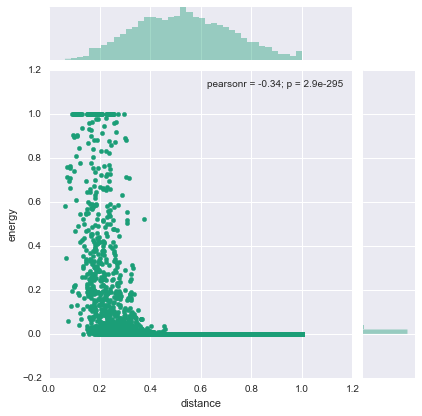

In [225]:
# Energy/distance correlation for each aa pair in CDR3alpha/antigen interaction
#
#marginal_kws=dict(name='Energy/distance correlation for each aa pair')
sns.set_style("darkgrid");
sns.jointplot(x='distance', y='energy', data=bufer);

### Total interaction energy of CDR3/antigen

Its interesting to plot distribution of total interaction energy of CDR3 region with antigen for alpha and beta chain separately, and then in combination to estimate possible energy values.
- - -

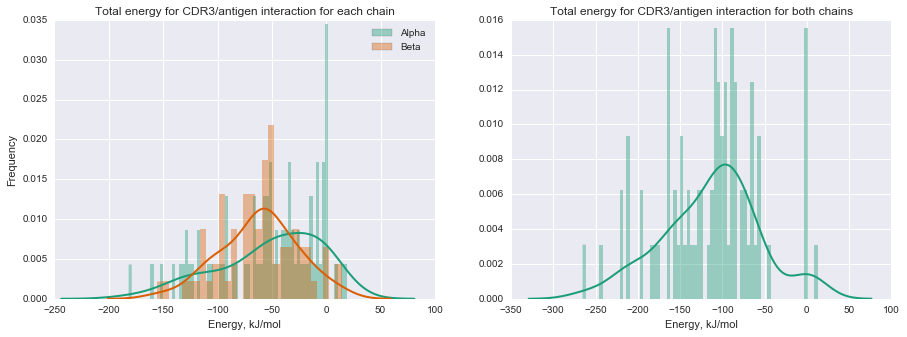

In [226]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.distplot(grouped_alpha['energy'].agg(sum), bins=70, label='Alpha')
sns.distplot(grouped_beta['energy'].agg(sum), bins=30, label='Beta')
plt.legend(loc='best')
plt.xlabel("Energy, kJ/mol")
plt.ylabel("Frequency")
plt.title("Total energy for CDR3/antigen interaction for each chain")

plt.subplot(122)
sns.distplot(grouped_alpha['energy'].agg(sum) + grouped_beta['energy'].agg(sum), bins=70, label='Alpha + Beta')
plt.title("Total energy for CDR3/antigen interaction for both chains")
plt.xlabel("Energy, kJ/mol");

### 4. Preferences in amino acid position 

First define some helper functions

In [227]:
# get square matrix for CDR3 and Antigen amino acids
# fm - data frame; ex.: gr.get_group('1ao7')
# col - either 'distance' or 'energy'
def get_matrix(fm, col):
    group = fm.reset_index()
    lenantigen = group.loc[0,'len_antigen']
    lentcr = group.loc[0,'len_tcr']
    mat = group.pivot('pos_antigen', 'pos_tcr', col)
    #hmap.columns = pd.MultiIndex.from_tuples(zip(range(lentcr), group['aa_tcr'][::lenantigen]))#
    mat.columns = group['aa_tcr'][:lentcr]
    #hmap.index = pd.MultiIndex.from_tuples(zip(range(lenantigen), group['aa_antigen'][:lenantigen]))
    mat.index = group['aa_antigen'][:lenantigen]
    return mat

In [228]:
# not used at the moment
'''hmap = get_matrix(grouped_alpha.get_group('1ao7'), 'distance')

min_loc = get_index(hmap, hmap.min().min()) 

min_borders = [[min_loc[0][0] - RANGE_RESTRAINTS, min_loc[0][0] + RANGE_RESTRAINTS + 1], \
               [min_loc[0][1] - RANGE_RESTRAINTS, min_loc[0][1] + RANGE_RESTRAINTS + 1]]
if min_borders[0][0] < 0:
    min_borders[0][0] = 0
if min_borders[1][0] < 0:
    min_borders[1][0] = 0
if min_borders[0][1] > hmap.shape[0]:
    min_borders[0][1] = hmap.shape[0]
if min_borders[1][1] > hmap.shape[1]:
    min_borders[1][1] = hmap.shape[1]'''
    
# get centered aa position
def rel_pos(fm, loc):
    return [loc[0] - fm.shape[0]/2, loc[1] - fm.shape[1]/2]

Now estimate the disribution of the position of the most interacting antigen amino acid. The process is as following: 
1. get the minimum pairwise distance for a particular complex
2. define the position of the antigen amino acid participating in this pair (0 is in the centre of the antigen)
3. collect the list of these positions for each TCR chain (alpha/beta)
- - -

In [229]:
# get a list of most interacting antigen aa position for each complex
def get_list_of_closest_aa_positions(grouped, flag):
    empty = []
    for name in pnames:
        min_dist = grouped.get_group(name)[flag].min()
        m = get_matrix(grouped.get_group(name), flag)
        empty.append(rel_pos(m, get_index(m, min_dist)[0])[0])
    return empty

# Desirable lists
antigen_closest_pos_alpha_list = get_list_of_closest_aa_positions(grouped_alpha, 'distance')
antigen_closest_pos_beta_list = get_list_of_closest_aa_positions(grouped_beta, 'distance')

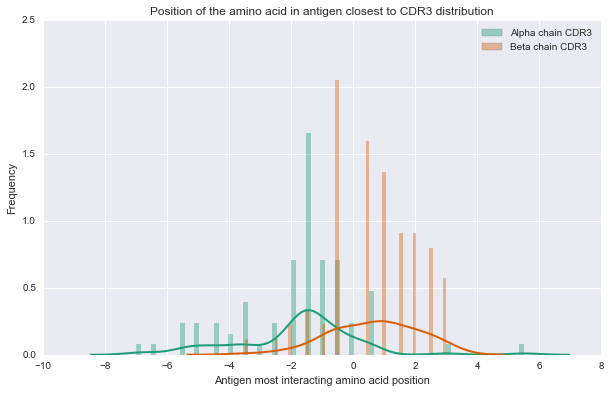

In [230]:
sns.set_style("darkgrid")
sns.distplot(antigen_closest_pos_alpha_list, bins=80, label='Alpha chain CDR3')
sns.distplot(antigen_closest_pos_beta_list, bins=60, label='Beta chain CDR3')
plt.xlabel('Antigen most interacting amino acid position')
plt.ylabel('Frequency')
plt.title('Position of the amino acid in antigen closest to CDR3 distribution')
plt.legend();

### 5. Number of contacting amino acids for each complex


Here histograms showing the distribution of the number of contacts of amino acid presented in the CDR3 region and the antigen for each complex are provided. For each complex the number of contacs for alpha and beta chains separately is collected using different distance thresholds. Blue line on each histogram corresponds to the mean number of contacts over all the complexes.
- - -

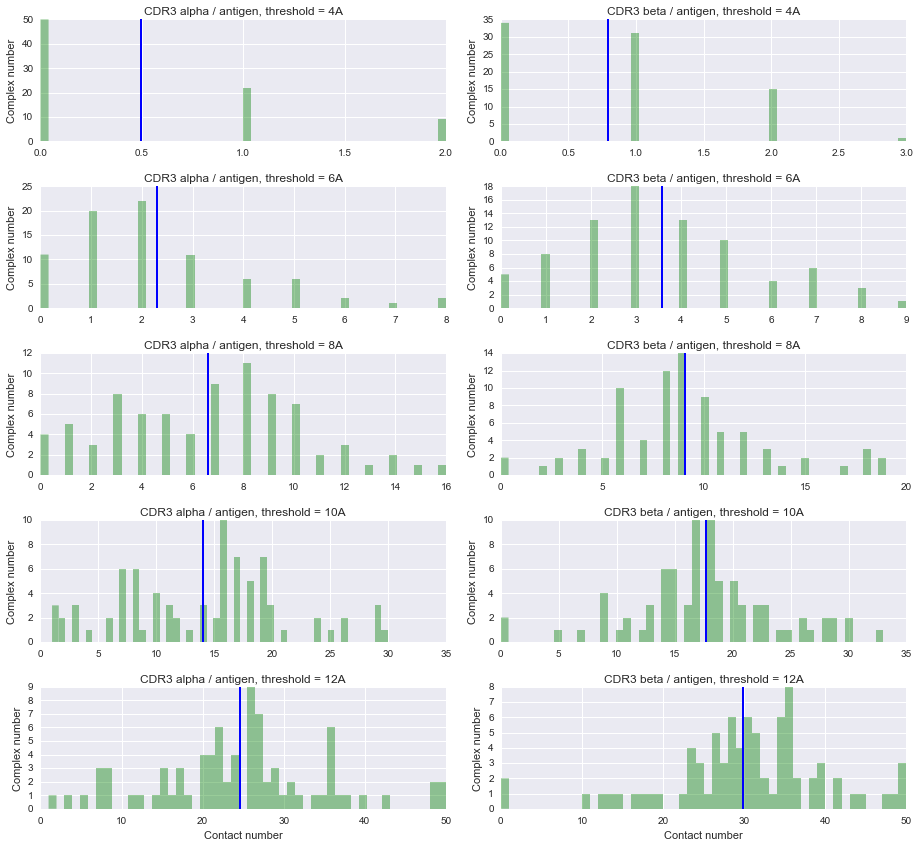

In [231]:
# list of number of contacts for each complex for particular threshold
def get_contact_list(grouped, threshold=DISTANCE_THRESHOLD):
    return [(grouped.get_group(name)['distance'] < threshold).sum() for name in grouped.groups.keys()]

# wrapper
def plot_contact_hist(x):
    sns.distplot(x, bins=50, norm_hist=False, kde=False, color='green')
    plt.axvline(x.mean())
    plt.ylabel("Complex number")

# plot settings
sns.set_style('darkgrid')
plt.figure(figsize=(13, 12))
dist_thresh_list = range(4, 13)[::2]

# plotting alpha hists
for i in dist_thresh_list:
    plt.subplot(5, 2, i - 3)
    x = np.array(get_contact_list(grouped_alpha, i))
    plot_contact_hist(x)
    plt.title("CDR3 alpha / antigen, threshold = " + str(i) + "A")
plt.xlabel("Contact number")

# plotting beta
for i in dist_thresh_list:
    plt.subplot(5, 2, i - 2)
    x = np.array(get_contact_list(grouped_beta, i))
    plot_contact_hist(x)
    plt.title("CDR3 beta / antigen, threshold = " + str(i) + "A")
    
plt.xlabel("Contact number")
plt.tight_layout()

Here the correlation between the number of contacts in the alpha chain and the number of contacts in the beta chain for each complex is presented. Again graphs are built for different distance thresholds.
- - -

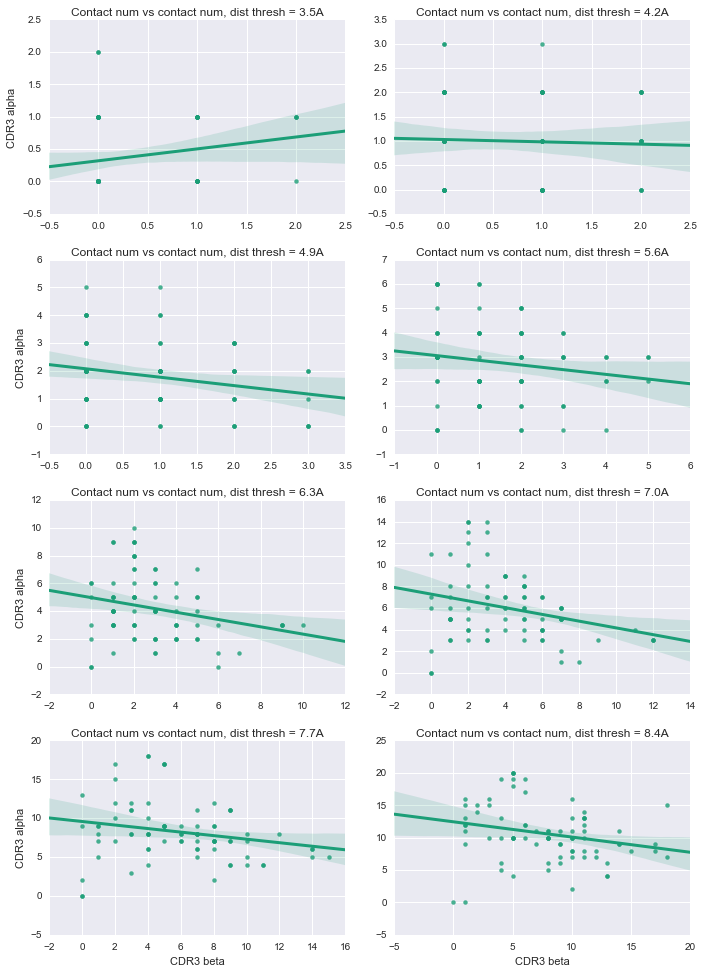

In [232]:
# Alpha/Beta contact number correlation
def draw_graph(x, y, thresh):
    sns.regplot(x, y)
    plt.title("Contact num vs contact num, dist thresh = " + str(thresh) + "A")

# Range of distance thresholds
dist_thresh_list = np.arange(3.5, 9., .7)#range(4, 15)[::2]
plt.figure(figsize=(10, 20))

# Plotting
sns.set_style('darkgrid')

plot_id = -1
for thresh in dist_thresh_list[::2]:
    
    plot_id += 2
    plt.subplot(6, 2, plot_id)
    alpha_contact_nums = get_contact_list(grouped_alpha, thresh)
    beta_contact_nums = get_contact_list(grouped_beta, thresh)
    draw_graph(np.array(alpha_contact_nums), np.array(beta_contact_nums), thresh)
    plt.ylabel("CDR3 alpha")
plt.xlabel("CDR3 beta")
    
plot_id = 0
for thresh in dist_thresh_list[1::2]:
    plot_id += 2
    plt.subplot(6, 2, plot_id)
    alpha_contact_nums = get_contact_list(grouped_alpha, thresh)
    beta_contact_nums = get_contact_list(grouped_beta, thresh)
    draw_graph(np.array(alpha_contact_nums), np.array(beta_contact_nums), thresh)
plt.xlabel("CDR3 beta")
plt.tight_layout()



### 6. CDR1/Antigen, CDR2/Antigen

Number of contacts for each region(CDR1, CDR2, CDR3) of alpha and beta chain
- - -

Getting desirable regions from the table

In [233]:
alpha_CDR1_filter = (table['tcr_region'] == 'CDR1') & (table['tcr_v_allele'].str.startswith('TRA'))
beta_CDR1_filter = (table['tcr_region'] == 'CDR1') & (table['tcr_v_allele'].str.startswith('TRB'))
alpha_CDR2_filter = (table['tcr_region'] == 'CDR2') & (table['tcr_v_allele'].str.startswith('TRA'))
beta_CDR2_filter = (table['tcr_region'] == 'CDR2') & (table['tcr_v_allele'].str.startswith('TRB'))
grouped_alpha_cdr1 = table[alpha_CDR1_filter].groupby('pdb_id')
grouped_beta_cdr1 = table[beta_CDR1_filter].groupby('pdb_id')
grouped_alpha_cdr2 = table[alpha_CDR2_filter].groupby('pdb_id')
grouped_beta_cdr2 = table[beta_CDR2_filter].groupby('pdb_id')

Getting dataframes with columns CDR1/2/3 contaning number of contacts woth antigen for alpha and beta separately

In [234]:
def get_equal_len_lists(*lists):
    length = max(map(lambda x: len(x), lists))
    return [l + [np.NAN] * (length - len(l)) for l in lists]

dict_alpha = dict(zip(['CDR1', 'CDR2', 'CDR3'], get_equal_len_lists(get_contact_list(grouped_alpha_cdr1), \
                                          get_contact_list(grouped_alpha_cdr2), \
                                          get_contact_list(grouped_alpha))))
dict_beta = dict(zip(['CDR1', 'CDR2', 'CDR3'], get_equal_len_lists(get_contact_list(grouped_beta_cdr1), \
                                          get_contact_list(grouped_beta_cdr2), \
                                          get_contact_list(grouped_beta))))
regions_contacts_alpha = pd.DataFrame(dict_alpha)
regions_contacts_beta = pd.DataFrame(dict_beta)

Drawing box plot

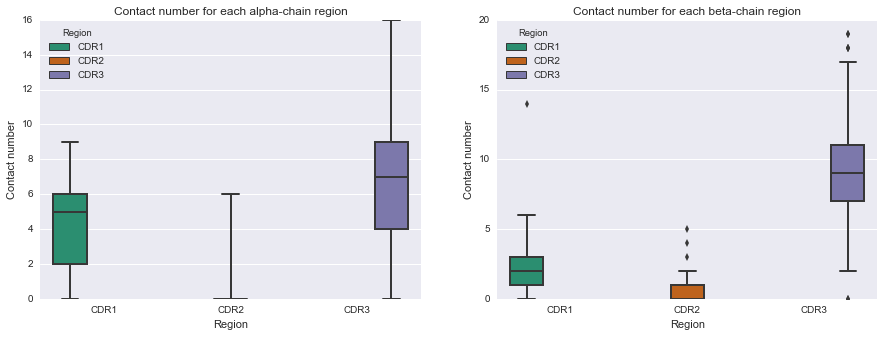

In [235]:
def contacts_box_plot(data):
    sns.boxplot(x="Region", y="Distance", hue="Region", \
            data=pd.melt(data, var_name='Region', value_name='Distance'));
    
plt.figure(figsize=(15, 5))
sns.set_style('darkgrid')

# Plotting
plt.subplot(121)
contacts_box_plot(regions_contacts_alpha)
plt.ylabel('Contact number')
plt.title('Contact number for each alpha-chain region')
plt.subplot(122)
contacts_box_plot(regions_contacts_beta)
plt.ylabel('Contact number')
plt.title('Contact number for each beta-chain region');

### 7. Amino acid interaction matrices

In [236]:
def empty_aa_mat():
    return pd.DataFrame(0, columns=alphabet, index=alphabet)

In [237]:
cdr3_table = table[table['tcr_region'] == 'CDR3']
glacer_matrix = pd.read_csv('glacer_interaction_table.txt', sep='\s+')
glacer_matrix.index = glacer_matrix.columns
glacer_matrix.sort_index(0, inplace=True)
glacer_matrix.sort_index(1, inplace=True)
#cdr3_table = cdr3_table[cdr3_table.tcr_v_allele.str.startswith('TRB')]
#cdr3_table.head()

---
Non-symmetrical interaction matrix:

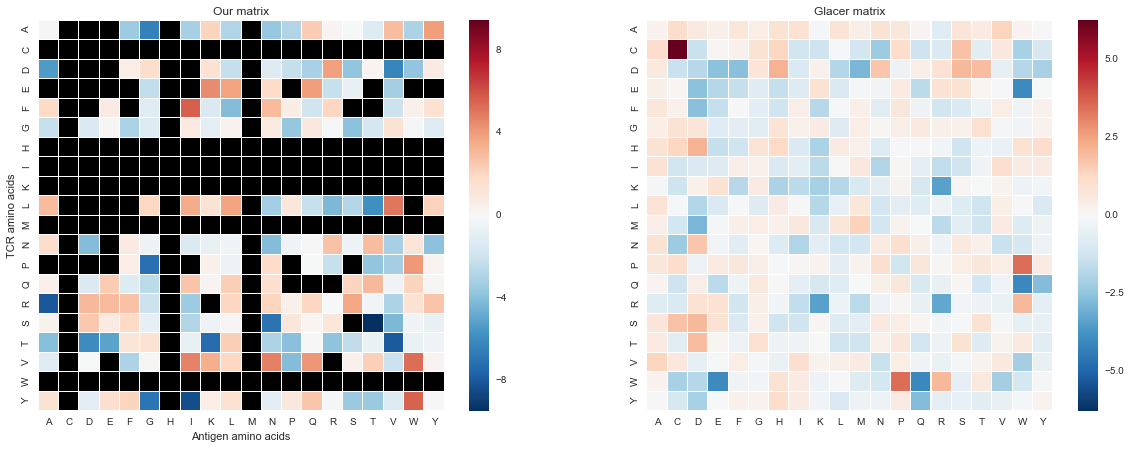

In [238]:
ENERGY_THRESHOLD = -1.0
MIN_CONTACTING_RES_NUM = 10

def get_neighbouring_aa_number_tcr(table, parameter, threshold):
    gr = table.groupby(['pdb_id', 'pos_tcr', 'tcr_v_allele', 'aa_tcr'])[parameter]
    ag = gr.agg(lambda x: any(x < threshold))
    aa_met = ag.index.levels[3]
    res = pd.Series([ag.xs(aa, level=3).sum() if aa in aa_met else 0 for aa in alphabet], index=alphabet)
    return res * (res > MIN_CONTACTING_RES_NUM)

def get_neighbouring_aa_number_antigen(table, parameter, threshold):
    gr = table.groupby(['pdb_id', 'pos_antigen', 'tcr_v_allele', 'aa_antigen'])[parameter]
    ag = gr.agg(lambda x: any(x < threshold))
    aa_met = ag.index.levels[3]
    res = pd.Series([ag.xs(aa, level=3).sum() if aa in aa_met else 0 for aa in alphabet], index=alphabet)
    return res * (res > MIN_CONTACTING_RES_NUM)

# count contact number for each pair
empty = empty_aa_mat() + cdr3_table.groupby(['aa_tcr', 'aa_antigen'])['energy'].agg(lambda x: sum(x < ENERGY_THRESHOLD)).unstack().fillna(0)
total_matrix = empty / empty.sum().sum()

# get contact number for each aa (taking each molecule into account only once)
contact_number_tcr = get_neighbouring_aa_number_tcr(cdr3_table, 'energy', ENERGY_THRESHOLD)
contact_number_tcr /= contact_number_tcr.sum()

contact_number_antigen = get_neighbouring_aa_number_antigen(cdr3_table, 'energy', ENERGY_THRESHOLD)
contact_number_antigen /= contact_number_antigen.sum()

total_matrix /= contact_number_tcr.to_frame().dot(contact_number_antigen.to_frame().T)
total_matrix = total_matrix.replace([0, np.inf], np.nan).apply(np.log10) * 10.0
total_matrix.sort_index(0, inplace=True)
total_matrix.sort_index(1, inplace=True)

sns.set(rc={'axes.facecolor':'black'})  
plt.figure(figsize=(20,7))
plt.subplot(121)
sns.heatmap(total_matrix, linewidths=0.01); 
plt.xlabel('Antigen amino acids');
plt.ylabel('TCR amino acids')
plt.title('Our matrix')
plt.subplot(122)
sns.heatmap(glacer_matrix, linewidths=0.01)
plt.title('Glacer matrix')
sns.set(rc={'axes.facecolor':'white'})

*Left - our matrix. Right - [Glaser et al.](http://onlinelibrary.wiley.com/doi/10.1002/1097-0134%2820010501%2943:2%3C89::AID-PROT1021%3E3.0.CO;2-H/full?2-H/full "Residue frequencies and pairing preferences at protein–protein interfaces")*

Numbers upon the bars stand for the numbers of particular residues 
participating in the interactions which belong to TCR or antigen


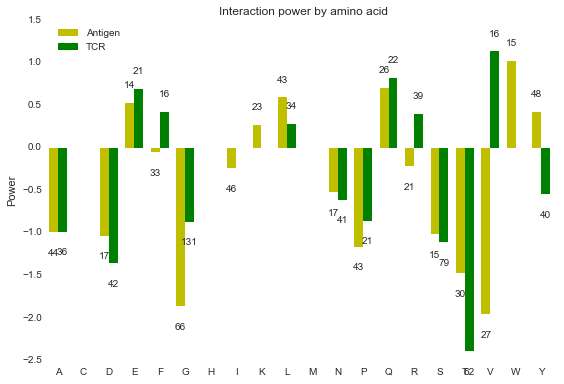

In [239]:
def plot_amino_acid_power(ax, matrix, parameter, threshold, width=0.35, std=False):
    N = len(alphabet)
    antigenMeans = list(matrix.apply(np.mean, axis=0))
    antigenStd = list(matrix.apply(np.std, axis=0)) if std else None

    ind = np.arange(N)    # the x locations for the groups

    rects1 = ax.bar(ind, antigenMeans, width, color='y', yerr=antigenStd)

    tcrMeans = list(matrix.apply(np.mean, axis=1))
    tcrStd = list(matrix.apply(np.std, axis=1)) if std else None

    rects2 = ax.bar(ind + width, tcrMeans, width, color='g', yerr=tcrStd)

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Power')
    ax.set_title('Interaction power by amino acid')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(sorted(alphabet))

    def autolabel(rects, nums):
        # attach some text labels
        for rect, num in zip(rects, nums):
            pos = rect.get_y()
            height = 0 if np.isnan(rect.get_height()) else rect.get_height()
            pos = pos - 0.3 if pos < 0 else height + 0.15
            num = '' if num == 0 else '%d' % num
            ax.text(rect.get_x() + rect.get_width()/2., pos, num, ha='center', va='bottom', size='smaller')
    autolabel(rects1, get_neighbouring_aa_number_antigen(cdr3_table, parameter, threshold).sort_index())
    autolabel(rects2, get_neighbouring_aa_number_tcr(cdr3_table, parameter, threshold).sort_index())

    ax.legend((rects1[0], rects2[0]), ('Antigen', 'TCR'), loc=2)
    print('Numbers upon the bars stand for the numbers of particular residues \nparticipating in the interactions which belong to TCR or antigen')
    plt.tight_layout()
    plt.show()
    
fig, ax = plt.subplots()
plot_amino_acid_power(ax, total_matrix, 'energy', ENERGY_THRESHOLD)

Energy threshold was chosen to be -1.0. The process of calculating matrix is described in *[Glaser et al.](http://onlinelibrary.wiley.com/doi/10.1002/1097-0134%2820010501%2943:2%3C89::AID-PROT1021%3E3.0.CO;2-H/full?2-H/full "Residue frequencies and pairing preferences at protein–protein interfaces")*. Black squares stand for the residues, which are presented by the number less than `MIN_CONTACTING_RES_NUM` across the dataset. 

The problem of the method used is that it takes into account only contacting residues and therefore reflects the probability for a particular residue to contact any other residues in a number more than one. What we need is the affinity of each amino acid to another one. Hence, not energetically contacting residues will be taken into account, but those residues, which lie in a particular distance `NEIGHBOURHOOD` far from each other. This should yield more relevant values.

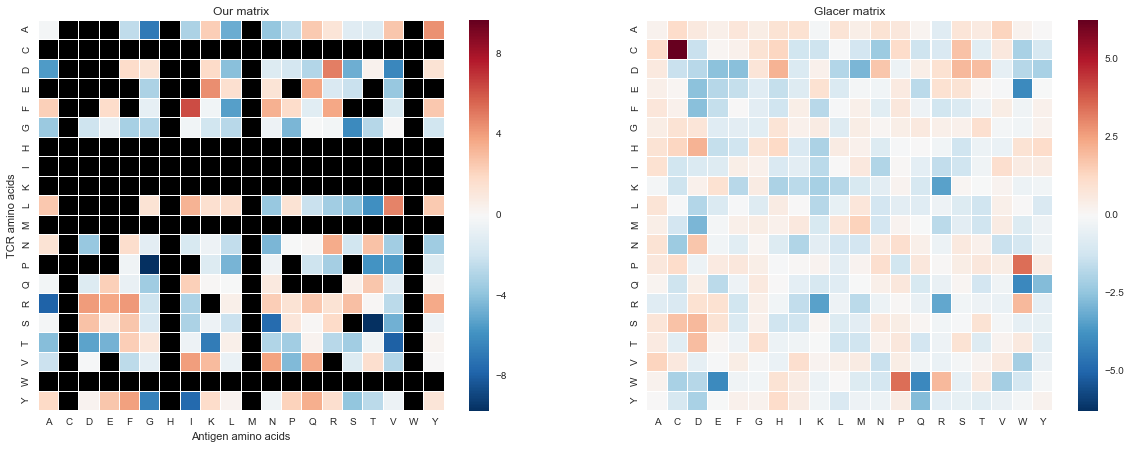

In [250]:
ENERGY_THRESHOLD = -1.0
NEIGHBOURHOOD = 8.0

# count contact number for each pair
empty = empty_aa_mat() + cdr3_table.groupby(['aa_tcr', 'aa_antigen']).energy.agg(lambda x: sum(x < ENERGY_THRESHOLD)).unstack().fillna(0)
total_matrix = empty / sum(cdr3_table.distance < NEIGHBOURHOOD)

# get contact number for each aa (taking each molecule into account only once)
contact_number_tcr = get_neighbouring_aa_number_tcr(cdr3_table, 'distance', NEIGHBOURHOOD)
contact_number_tcr /= contact_number_tcr.sum()

contact_number_antigen = get_neighbouring_aa_number_antigen(cdr3_table, 'distance', NEIGHBOURHOOD)
contact_number_antigen /= contact_number_antigen.sum()

total_matrix /= contact_number_tcr.to_frame().dot(contact_number_antigen.to_frame().T)
total_matrix = total_matrix.replace([0, np.inf], np.nan).apply(np.log10) * 10.0
total_matrix.sort_index(0, inplace=True)
total_matrix.sort_index(1, inplace=True)

sns.set(rc={'axes.facecolor':'black'})  
plt.figure(figsize=(20,7))
plt.subplot(121)
sns.heatmap(total_matrix, linewidths=0.01); 
plt.xlabel('Antigen amino acids');
plt.ylabel('TCR amino acids')
plt.title('Our matrix')
plt.subplot(122)
sns.heatmap(glacer_matrix, linewidths=0.01)
plt.title('Glacer matrix')
sns.set(rc={'axes.facecolor':'white'})

Numbers upon the bars stand for the numbers of particular residues 
participating in the interactions which belong to TCR or antigen


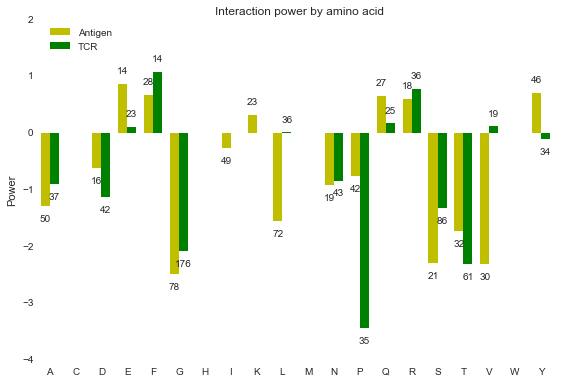

In [251]:
fig, ax = plt.subplots()
plot_amino_acid_power(ax, total_matrix, 'distance', NEIGHBOURHOOD)

*The picture above should be the most relevant for TCR/peptide studies.*

----
Try to find correlation with hydrofobicity

In [252]:
hydfob = cdr3_surface_tool.aa_props.hydrophobicity

hydfob_mat = hydfob.to_frame().dot(hydfob.to_frame().transpose())
hydfob_mat.sort_index(0, inplace=True)
hydfob_mat.sort_index(1, inplace=True)

In [253]:
def triangle_mat(m):
    a = m.copy()
    for i in range(a.shape[0]):
        for j in range(i):
            a.iloc[i, j] = np.nan
    return a

In [301]:
def correlate_tables_many(*m):
    lists = []
    for mat in m:
        temp = mat.reset_index()
        temp.columns = ['index']+list(temp.columns)[1:]
        lists.append(pd.melt(temp, id_vars=['index']).value)  
    return lists

def correlate_tables(a, b):  
    temp = a.reset_index()
    temp.columns = ['index']+list(temp.columns)[1:]
    a_list = pd.melt(temp, id_vars=['index']).value
    temp = b.reset_index()
    temp.columns = ['index']+list(temp.columns)[1:]
    b_list = pd.melt(b.reset_index(), id_vars=['index']).value
    condition = (a_list.apply(np.isnan) == False) & (b_list.apply(np.isnan) == False)
    a_list = a_list[condition]
    b_list = b_list[condition]
    return a_list, b_list

Correlation coefficients:  0.231545692314 (left),  0.164751236155 (right)


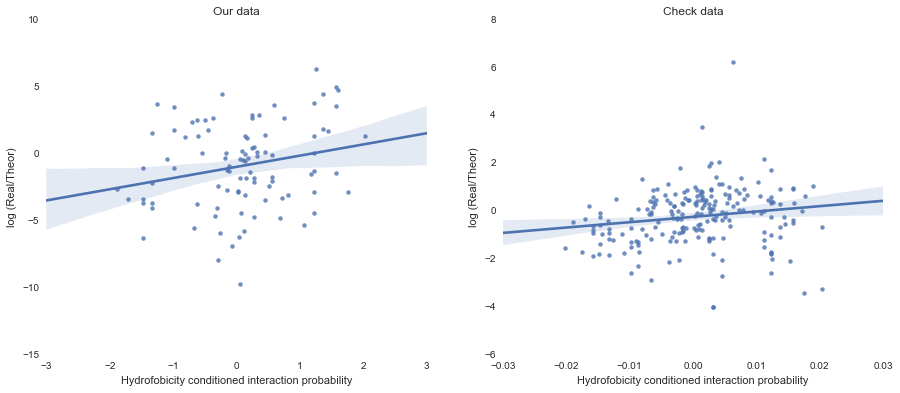

In [302]:
plt.figure(figsize=(15,6))

plt.subplot(121)
hydfob_list, mat_fin_list = correlate_tables(hydfob_mat / 10, triangle_mat(total_matrix))
sns.regplot(hydfob_list, mat_fin_list)
plt.xlabel('Hydrofobicity conditioned interaction probability')
plt.ylabel('log (Real/Theor)')
plt.title('Our data')
coef_left = np.corrcoef(hydfob_list, mat_fin_list)[0, 1]

plt.subplot(122)
hydfob_list, mat_fin_list = correlate_tables(hydfob_mat / 1000, triangle_mat(glacer_matrix))
sns.regplot(hydfob_list, mat_fin_list)
plt.xlabel('Hydrofobicity conditioned interaction probability')
plt.ylabel('log (Real/Theor)')
plt.title('Check data')
coef_right = np.corrcoef(hydfob_list, mat_fin_list)[0, 1]

print('Correlation coefficients: ', coef_left, '(left), ', coef_right, '(right)')

In [303]:
nrg_mat = pd.DataFrame(pd.read_table('miyazava_table.txt'))
nrg_mat.index = nrg_mat.columns
for i in range(nrg_mat.shape[0]):
    for j in range(i):
        nrg_mat.iloc[i, j] = nrg_mat.iloc[j, i]
nrg_mat.sort_index(0, inplace=True)
nrg_mat.sort_index(1, inplace=True)
nrg_mat.head()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A,-2.72,-3.57,-1.70,-1.51,-4.81,-2.31,-2.41,-4.58,-1.31,-4.91,-3.94,-1.84,-2.03,-1.89,-1.83,-2.01,-2.32,-4.04,-3.82,-3.36
C,-3.57,-5.44,-2.41,-2.27,-5.80,-3.16,-3.60,-5.50,-1.95,-5.83,-4.99,-2.59,-3.07,-2.85,-2.57,-2.86,-3.11,-4.96,-4.95,-4.16
D,-1.70,-2.41,-1.21,-1.02,-3.48,-1.59,-2.32,-3.17,-1.68,-3.40,-2.57,-1.68,-1.33,-1.46,-2.29,-1.63,-1.80,-2.48,-2.84,-2.76
E,-1.51,-2.27,-1.02,-0.91,-3.56,-1.22,-2.15,-3.27,-1.80,-3.59,-2.89,-1.51,-1.26,-1.42,-2.27,-1.48,-1.74,-2.67,-2.99,-2.79
F,-4.81,-5.80,-3.48,-3.56,-7.26,-4.13,-4.77,-6.84,-3.36,-7.28,-6.56,-3.75,-4.25,-4.10,-3.98,-4.02,-4.28,-6.29,-6.16,-5.66


Correlation coefficients:  -0.0887663012111 (left),  -0.103176755466 (right)


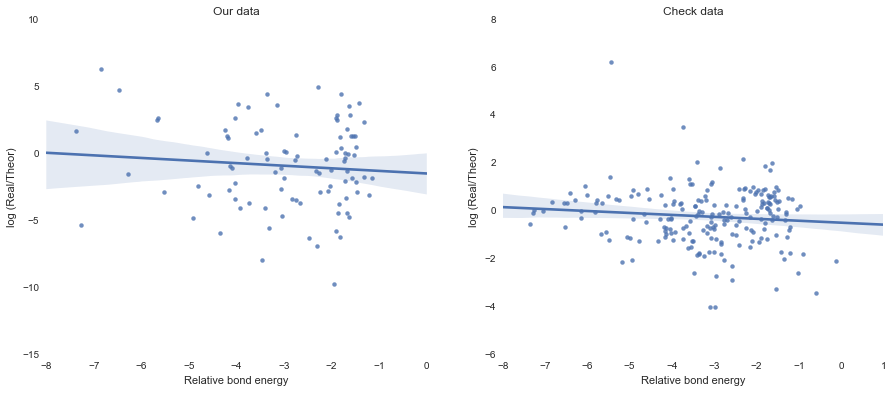

In [304]:
plt.figure(figsize=(15,6))

plt.subplot(121)
mat_fin_list, nrg_list = correlate_tables(triangle_mat(total_matrix), nrg_mat)
sns.regplot(nrg_list, mat_fin_list)
plt.xlabel('Relative bond energy')
plt.ylabel('log (Real/Theor)')
plt.title('Our data')
coef_left = np.corrcoef(nrg_list, mat_fin_list)[0, 1]

plt.subplot(122)
mat_fin_list, nrg_list = correlate_tables(triangle_mat(glacer_matrix), nrg_mat)
sns.regplot(nrg_list, mat_fin_list, 'bo')
plt.xlabel('Relative bond energy')
plt.ylabel('log (Real/Theor)')
plt.title('Check data')
coef_right = np.corrcoef(mat_fin_list, nrg_list)[0, 1]

print('Correlation coefficients: ', coef_left, '(left), ', coef_right, '(right)')

Pearson coef:  -0.156694168212


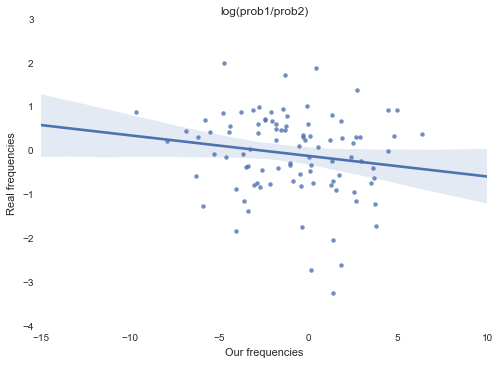

In [305]:
list1, list2 = correlate_tables(triangle_mat(total_matrix), glacer_matrix)
sns.regplot(list1, list2)
plt.xlabel('Our frequencies')
plt.ylabel('Real frequencies')
plt.title('log(prob1/prob2)')
print('Pearson coef: ', np.corrcoef(list1, list2)[0, 1])

		Our frequencies, Check frequencies, Bond energies, Hydrophobisity


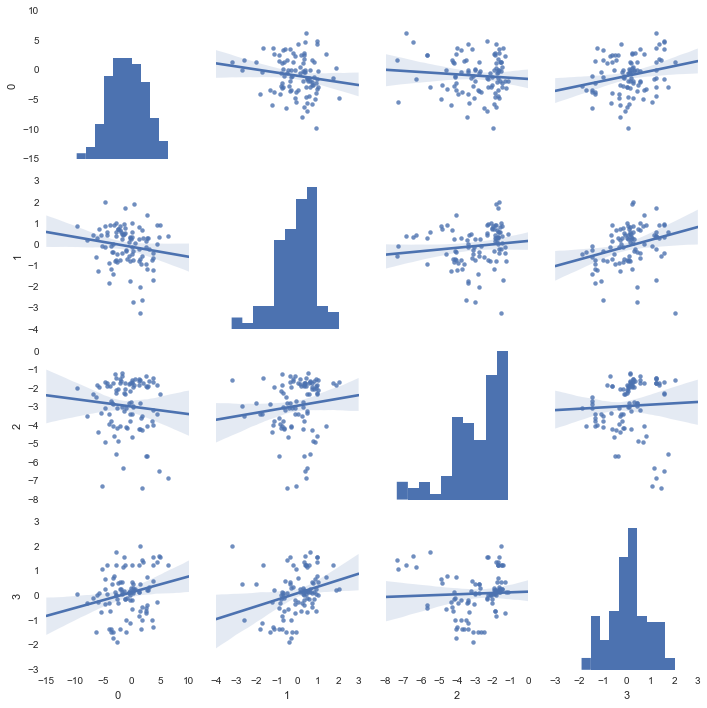

In [306]:
df = pd.DataFrame(correlate_tables_many(triangle_mat(total_matrix), triangle_mat(glacer_matrix), 
                                        triangle_mat(nrg_mat), hydfob_mat/10), index=range(4)).dropna(1).transpose()

sns.pairplot(df, kind='reg');
print('\t\tOur frequencies, Check frequencies, Bond energies, Hydrophobisity')

### 9. Energy 

#### Plot CDR1

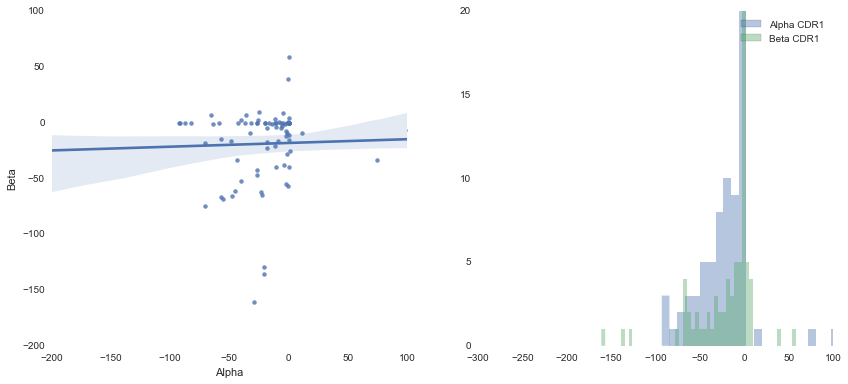

In [307]:
loc_table = table.dropna()

grouped = loc_table[(loc_table['tcr_region'] == 'CDR1') & (loc_table['tcr_v_allele'].str.startswith('TRA'))].groupby('pdb_id')
energies_alpha = [sum(grouped.get_group(x).dropna()['energy']) for x in grouped.groups.keys()]

grouped = loc_table[(loc_table['tcr_region'] == 'CDR1') & (loc_table['tcr_v_allele'].str.startswith('TRB'))].groupby('pdb_id')
energies_beta = [sum(grouped.get_group(x).dropna()['energy']) for x in grouped.groups.keys()]

plt.figure(figsize=(14,6)); plt.subplot(121);
sns.regplot(np.array(energies_alpha), np.array(energies_beta))
plt.axis([-200, 100, -200, 100]); plt.xlabel('Alpha'); plt.ylabel('Beta')

plt.subplot(122)
sns.distplot(energies_alpha, kde=False, label='Alpha CDR1', bins=100)
sns.distplot(energies_beta, kde=False, label='Beta CDR1', bins=50)
plt.axis([-300, 100, 0, 20]); plt.legend()

#### Plot CDR2

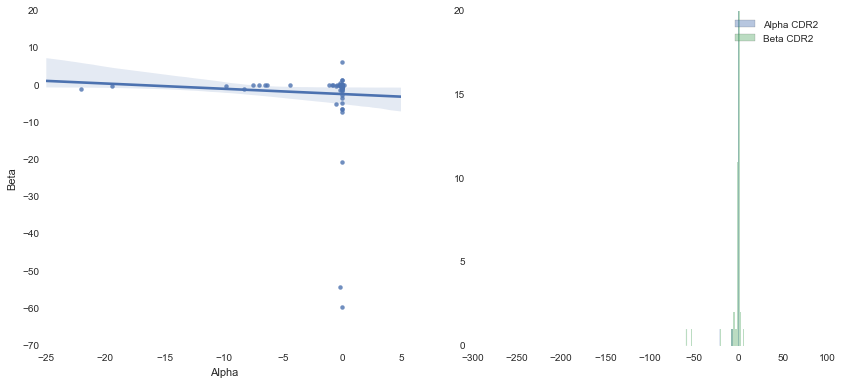

In [309]:

grouped = loc_table[(loc_table['tcr_region'] == 'CDR2') & (loc_table['tcr_v_allele'].str.startswith('TRA'))].groupby('pdb_id')
energies_alpha = [sum(grouped.get_group(x)['energy']) for x in grouped.groups.keys()]

grouped = loc_table[(loc_table['tcr_region'] == 'CDR2') & (loc_table['tcr_v_allele'].str.startswith('TRB'))].groupby('pdb_id')
energies_beta = [sum(grouped.get_group(x)['energy']) for x in grouped.groups.keys()]

plt.figure(figsize=(14,6)); plt.subplot(121);
sns.regplot(np.array(energies_alpha), np.array(energies_beta))
plt.xlabel('Alpha'); plt.ylabel('Beta');

plt.subplot(122)
sns.distplot(energies_alpha, kde=False, label='Alpha CDR2', bins=50)
sns.distplot(energies_beta, kde=False, label='Beta CDR2', bins=50)
plt.axis([-300, 100, 0, 20]); plt.legend()

#### Plot CDR3

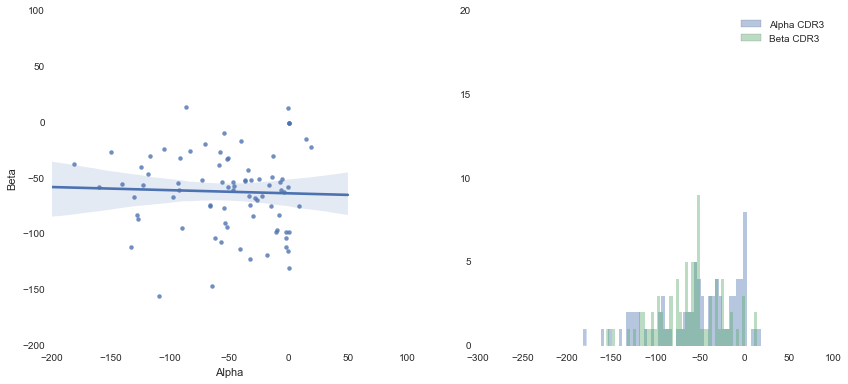

In [310]:
grouped = loc_table[(loc_table['tcr_region'] == 'CDR3') & (loc_table['tcr_v_allele'].str.startswith('TRA'))].groupby('pdb_id')
energies_alpha = [sum(grouped.get_group(x)['energy']) for x in grouped.groups.keys()]

grouped = loc_table[(loc_table['tcr_region'] == 'CDR3') & (loc_table['tcr_v_allele'].str.startswith('TRB'))].groupby('pdb_id')
energies_beta = [sum(grouped.get_group(x)['energy']) for x in grouped.groups.keys()]

plt.figure(figsize=(14,6)); plt.subplot(121);
sns.regplot(np.array(energies_alpha), np.array(energies_beta), fit_reg=True)
plt.xlabel('Alpha'); plt.ylabel('Beta'); plt.axis([-200, 100, -200, 100]);

plt.subplot(122)
sns.distplot(energies_alpha, kde=False, label='Alpha CDR3', bins=50)
sns.distplot(energies_beta, kde=False, label='Beta CDR3', bins=50)
plt.axis([-300, 100, 0, 20]); plt.legend()

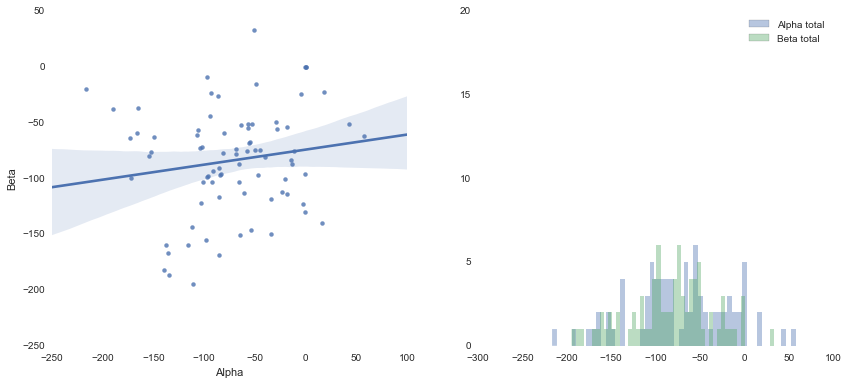

In [311]:
grouped = loc_table[(loc_table['tcr_v_allele'].str.startswith('TRA'))].groupby('pdb_id')
energies_alpha = pd.Series([sum(grouped.get_group(x)['energy']) for x in grouped.groups.keys()])

grouped = loc_table[(loc_table['tcr_v_allele'].str.startswith('TRB'))].groupby('pdb_id')
energies_beta = pd.Series([sum(grouped.get_group(x)['energy']) for x in grouped.groups.keys()])[energies_alpha < 100]

energies_alpha = energies_alpha[energies_alpha < 100]

plt.figure(figsize=(14,6)); plt.subplot(121);
sns.regplot(np.array(energies_alpha), np.array(energies_beta))
plt.xlabel('Alpha'); plt.ylabel('Beta');

plt.subplot(122)
sns.distplot(energies_alpha, kde=False, label='Alpha total', bins=50)
sns.distplot(energies_beta, kde=False, label='Beta total', bins=50)
plt.axis([-300, 100, 0, 20]); plt.legend()

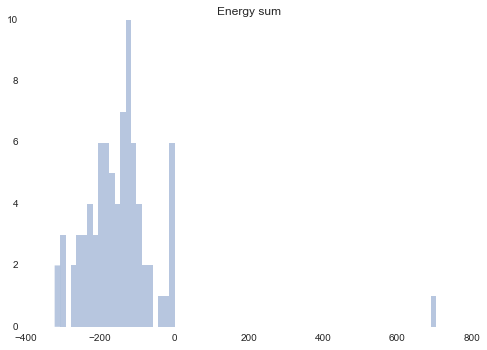

In [312]:
grouped = table.dropna().groupby('pdb_id')
sns.distplot([sum(grouped.get_group(x)['energy']) for x in grouped.groups.keys()], kde=False, bins=70)
plt.title('Energy sum')